<a href="https://colab.research.google.com/github/aholloman79/A-Primer-on-Scientific-Programming-with-Python/blob/master/Applying_Generalized_Linear_Models_for_Financial_Data_Modeling_and_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

No missing values found, so I can proceed confidently.
I found outliers in market_conditions. Removing these rows.
No significant outliers in customer_age.
I found outliers in economic_index. Removing these rows.
I found outliers in event_counts. Removing these rows.
                 Generalized Linear Model Regression Results                  
Dep. Variable:           event_counts   No. Observations:                  978
Model:                            GLM   Df Residuals:                      974
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1785.7
Date:                Sun, 15 Dec 2024   Deviance:                       960.21
Time:                        13:43:56   Pearson chi2:                     827.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.6727
Covariance Type:     

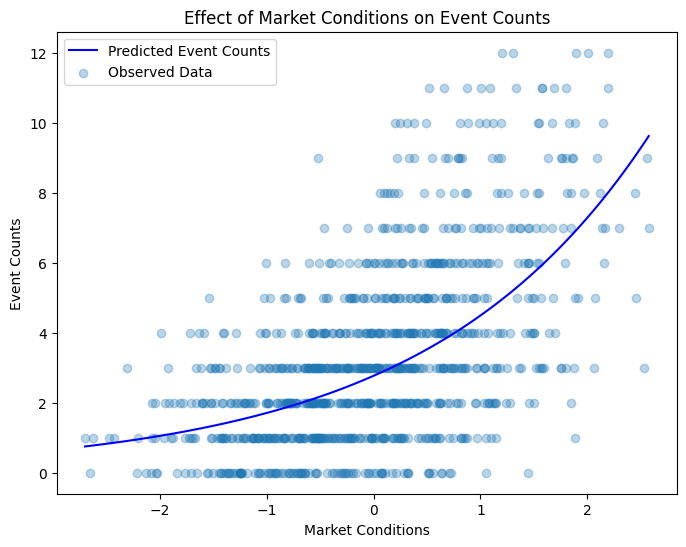

In [1]:
# Importing the libraries I need for this analysis.
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# I want my analysis to be reproducible, so I'm setting a random seed.
np.random.seed(42)

# I'll start by creating synthetic data. This will simulate a financial dataset
# where the response variable is count data influenced by a few predictors.
n_samples = 1000

# Generating predictor variables that make sense in a financial context.
market_conditions = np.random.normal(loc=0, scale=1, size=n_samples)
customer_age = np.random.uniform(low=18, high=65, size=n_samples)
economic_index = np.random.normal(loc=50, scale=10, size=n_samples)

# For the response variable, I'll use a Poisson distribution because I'm modeling count data.
# I'm using the exponential function to ensure the response variable remains non-negative.
lambda_mean = np.exp(0.5 * market_conditions + 0.3 * customer_age / 10 - 0.2 * economic_index / 50)
event_counts = np.random.poisson(lam=lambda_mean)

# Combining everything into a DataFrame so it's easier for me to work with.
data = pd.DataFrame({
    'market_conditions': market_conditions,
    'customer_age': customer_age,
    'economic_index': economic_index,
    'event_counts': event_counts
})

# Before proceeding, I want to clean the data to ensure there are no missing or inconsistent values.
# Although my synthetic data shouldn't have issues, I still want to apply good practices.
if data.isnull().sum().sum() > 0:
    data.dropna(inplace=True)  # Dropping rows with missing values if there are any.
    print("I noticed missing values and removed them.")
else:
    print("No missing values found, so I can proceed confidently.")

# I'll also check for outliers, especially in the numeric columns.
# Extreme outliers might skew the results, so I'll handle them appropriately.
numeric_cols = ['market_conditions', 'customer_age', 'economic_index', 'event_counts']
for col in numeric_cols:
    upper_limit = data[col].mean() + 3 * data[col].std()
    lower_limit = data[col].mean() - 3 * data[col].std()
    outliers = data[(data[col] > upper_limit) | (data[col] < lower_limit)]
    if not outliers.empty:
        print(f"I found outliers in {col}. Removing these rows.")
        data = data[(data[col] <= upper_limit) & (data[col] >= lower_limit)]
    else:
        print(f"No significant outliers in {col}.")

# Now, I feel confident about the quality of my data and can proceed to modeling.

# I'll fit a Poisson regression model to capture the relationship between the predictors and the response.
poisson_model = smf.glm(
    formula="event_counts ~ market_conditions + customer_age + economic_index",
    data=data,
    family=sm.families.Poisson()
).fit()

# I'm curious about the summary of this model, so I'll print it out.
print(poisson_model.summary())

# I know that overdispersion is a common issue with Poisson models, so I'll check for it.
residual_deviance = poisson_model.deviance
degrees_of_freedom = poisson_model.df_resid
overdispersion_ratio = residual_deviance / degrees_of_freedom

print(f"I calculated an overdispersion ratio of {overdispersion_ratio:.2f}.")
if overdispersion_ratio > 1.5:
    print("Overdispersion detected. I'll consider a Negative Binomial model.")
    neg_bin_model = smf.glm(
        formula="event_counts ~ market_conditions + customer_age + economic_index",
        data=data,
        family=sm.families.NegativeBinomial()
    ).fit()
    print(neg_bin_model.summary())

# I'm interested in visualizing how market conditions influence event counts.
market_conditions_seq = np.linspace(data['market_conditions'].min(), data['market_conditions'].max(), 100)

predicted_counts = poisson_model.predict(
    pd.DataFrame({
        'market_conditions': market_conditions_seq,
        'customer_age': np.mean(data['customer_age']),
        'economic_index': np.mean(data['economic_index'])
    })
)

plt.figure(figsize=(8, 6))
plt.plot(market_conditions_seq, predicted_counts, label="Predicted Event Counts", color="blue")
plt.scatter(data['market_conditions'], data['event_counts'], alpha=0.3, label="Observed Data")
plt.title("Effect of Market Conditions on Event Counts")
plt.xlabel("Market Conditions")
plt.ylabel("Event Counts")
plt.legend()
plt.show()
